## Libraries


In [1]:
# !pip install -r ~/code/benitomartin/FoodScore/requirements.txt

In [97]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from sklearn.preprocessing import LabelEncoder, LabelBinarizer


import pickle

## Data import

In [3]:
coord = pd.DataFrame()

for i in range(1, 3, 1):
    path = f"../raw_data/UECFOOD256/{i}"
    data = pd.read_csv(f"{path}/bb_info.txt", sep=' ', header=0, index_col="img")
    data_df = pd.DataFrame(data)
    data_df["label"] = i
    coord = pd.concat([coord, data_df])
    


In [4]:
coord = coord.reset_index()

### DataFrame with label and coordinates

In [5]:
coord.shape

(756, 6)

In [6]:
coord.head()

,img,x1,y1,x2,y2,label
0,1,0,143,370,486,1
1,2,20,208,582,559,1
2,3,2,110,243,410,1
3,4,0,237,286,536,1
4,5,8,28,761,585,1


In [7]:
coord = coord.rename(columns={"img": "img_name"})

In [8]:
coord.head()

,img_name,x1,y1,x2,y2,label
0,1,0,143,370,486,1
1,2,20,208,582,559,1
2,3,2,110,243,410,1
3,4,0,237,286,536,1
4,5,8,28,761,585,1


### Rescaling and Normalization

In [9]:
coord.head()

,img_name,x1,y1,x2,y2,label
0,1,0,143,370,486,1
1,2,20,208,582,559,1
2,3,2,110,243,410,1
3,4,0,237,286,536,1
4,5,8,28,761,585,1


In [10]:
list_height = []
list_width = []

for index, row in coord.iterrows():
    
    image_path = f"../raw_data/UECFOOD256/{int(row['label'])}/{int(row['img_name'])}.jpg"
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
     
    list_height.append(h)
    list_width.append(w)   

In [11]:
print(len(list_height))

756


In [12]:
coord.shape

(756, 6)

In [13]:
coord["width"] = pd.DataFrame(list_width)
coord["height"] = pd.DataFrame(list_height)

In [14]:
coord.head()

,img_name,x1,y1,x2,y2,label,width,height
0,1,0,143,370,486,1,800,600
1,2,20,208,582,559,1,800,600
2,3,2,110,243,410,1,800,600
3,4,0,237,286,536,1,800,600
4,5,8,28,761,585,1,800,600


In [15]:
coord.tail()

,img_name,x1,y1,x2,y2,label,width,height
751,15481,41,33,531,442,2,600,450
752,15650,27,152,258,312,2,600,360
753,15652,295,101,596,407,2,600,450
754,15852,57,16,573,336,2,600,360
755,16109,43,12,442,640,2,480,640


In [16]:
coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   img_name  756 non-null    int64
 1   x1        756 non-null    int64
 2   y1        756 non-null    int64
 3   x2        756 non-null    int64
 4   y2        756 non-null    int64
 5   label     756 non-null    int64
 6   width     756 non-null    int64
 7   height    756 non-null    int64
dtypes: int64(8)
memory usage: 47.4 KB


In [17]:
rescaled_coord = coord[["img_name", "label"]]

In [18]:
rescaled_coord.head()

,img_name,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [19]:
rescaled_coord["x1"] = (coord["x1"]/coord["width"])
rescaled_coord["y1"] = (coord["y1"]/coord["height"])
rescaled_coord["x2"] = (coord["x2"]/coord["width"])
rescaled_coord["y2"] = (coord["y2"]/coord["height"])

/tmp/ipykernel_16310/269966774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rescaled_coord["x1"] = (coord["x1"]/coord["width"])
/tmp/ipykernel_16310/269966774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rescaled_coord["y1"] = (coord["y1"]/coord["height"])
/tmp/ipykernel_16310/269966774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [20]:
rescaled_coord.head()

,img_name,label,x1,y1,x2,y2
0,1,1,0.0000,0.238333,0.46250,0.810000
1,2,1,0.0250,0.346667,0.72750,0.931667
2,3,1,0.0025,0.183333,0.30375,0.683333
3,4,1,0.0000,0.395000,0.35750,0.893333
4,5,1,0.0100,0.046667,0.95125,0.975000


In [21]:
list_paths = []

for index, row in coord.iterrows():
    
    image_path = f"../raw_data/UECFOOD256/{int(row['label'])}/{int(row['img_name'])}.jpg"
    list_paths.append(image_path)

In [22]:
rescaled_coord["paths"] = pd.DataFrame(list_paths)

/tmp/ipykernel_16310/2402959842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rescaled_coord["paths"] = pd.DataFrame(list_paths)


In [23]:
rescaled_coord.head()

,img_name,label,x1,y1,x2,y2,paths
0,1,1,0.0000,0.238333,0.46250,0.810000,../raw_data/UECFOOD256/1/1.jpg
1,2,1,0.0250,0.346667,0.72750,0.931667,../raw_data/UECFOOD256/1/2.jpg
2,3,1,0.0025,0.183333,0.30375,0.683333,../raw_data/UECFOOD256/1/3.jpg
3,4,1,0.0000,0.395000,0.35750,0.893333,../raw_data/UECFOOD256/1/4.jpg
4,5,1,0.0100,0.046667,0.95125,0.975000,../raw_data/UECFOOD256/1/5.jpg


In [24]:
data = []

for index, row in rescaled_coord.iterrows():
    
    image = load_img(row["paths"], target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
    

In [25]:
data[0]

array([[[ 16.,  18.,  13.],
        [ 22.,  24.,  21.],
        [ 19.,  20.,  14.],
        ...,
        [ 74.,  82.,  69.],
        [ 83.,  89.,  75.],
        [ 76.,  82.,  68.]],

       [[ 17.,  17.,  17.],
        [ 19.,  19.,  21.],
        [ 22.,  22.,  22.],
        ...,
        [ 70.,  78.,  65.],
        [ 84.,  92.,  79.],
        [ 85.,  93.,  80.]],

       [[ 24.,  27.,  20.],
        [ 19.,  20.,  15.],
        [ 22.,  23.,  17.],
        ...,
        [ 64.,  70.,  60.],
        [ 66.,  67.,  61.],
        [ 89.,  89.,  81.]],

       ...,

       [[121., 124., 115.],
        [141., 152., 144.],
        [154., 166., 162.],
        ...,
        [234., 240., 204.],
        [244., 249., 217.],
        [236., 242., 208.]],

       [[117., 122., 118.],
        [133., 145., 141.],
        [151., 166., 163.],
        ...,
        [245., 250., 228.],
        [240., 248., 227.],
        [247., 250., 231.]],

       [[117., 123., 111.],
        [141., 153., 149.],
        [144., 1

In [26]:
data = np.array(data, dtype="float32") / 255.0

In [27]:
labels = np.array(list(rescaled_coord["label"]))
type(labels[0])

numpy.int64

In [98]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [99]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)

two classes


In [100]:
labels[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [101]:
img_paths = np.array(list(rescaled_coord["paths"]))

In [102]:
img_paths[:3]

array(['../raw_data/UECFOOD256/1/1.jpg', '../raw_data/UECFOOD256/1/2.jpg',
       '../raw_data/UECFOOD256/1/3.jpg'], dtype='<U34')

In [103]:
bboxes = []

for index, row in rescaled_coord.iterrows():
    
    x1 = row["x1"]
    y1 = row["y1"]
    x2 = row["x2"]
    y2 = row["y2"]
    bboxes.append((x1, y1, x2, y2))
    
    

In [104]:
bboxes = np.array(bboxes, dtype="float32")
bboxes[0]

array([0.        , 0.23833333, 0.4625    , 0.81      ], dtype=float32)

### Test Train Split

In [105]:
(trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths) = \
train_test_split(data,
                  labels,
                  bboxes,
                  img_paths,
                  test_size=0.20,
                  random_state=42)

In [106]:
np.shape(trainImages)[1:]

(224, 224, 3)

In [107]:
len(trainLabels)

604

In [108]:
trainLabels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Model

In [109]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=layers.Input(shape=(224, 224, 3)))


vgg.trainable = False

flatten = vgg.output
flatten = layers.Flatten()(flatten)

bboxHead = layers.Dense(128, activation="relu")(flatten)
bboxHead = layers.Dense(64, activation="relu")(bboxHead)
bboxHead = layers.Dense(32, activation="relu")(bboxHead)
bboxHead = layers.Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

softmaxHead = layers.Dense(512, activation="relu")(flatten)
softmaxHead = layers.Dropout(0.5)(softmaxHead)
softmaxHead = layers.Dense(512, activation="relu")(softmaxHead)
softmaxHead = layers.Dropout(0.5)(softmaxHead)
softmaxHead = layers.Dense(2, activation="softmax", name="class_label")(softmaxHead)


In [110]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [111]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error"
}

In [112]:
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [113]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

In [114]:
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [115]:
metrics = {
    "class_label": "accuracy",
    "bounding_box": "mse"
}

In [116]:
opt = Adam(0.001)


model.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"], 
              loss_weights=lossWeights)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [117]:
np.shape(trainTargets)

()

In [118]:
history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=10,
    verbose=1)

Epoch 1/10
19/19 [==============================] - 60s 3s/step - loss: 1.4992 - bounding_box_loss: 0.1120 - class_label_loss: 1.3871 - bounding_box_accuracy: 0.5911 - class_label_accuracy: 0.8046 - val_loss: 0.2541 - val_bounding_box_loss: 0.0577 - val_class_label_loss: 0.1965 - val_bounding_box_accuracy: 0.7171 - val_class_label_accuracy: 0.9474
Epoch 2/10
19/19 [==============================] - 41s 2s/step - loss: 0.5179 - bounding_box_loss: 0.0556 - class_label_loss: 0.4623 - bounding_box_accuracy: 0.6523 - class_label_accuracy: 0.9354 - val_loss: 0.2372 - val_bounding_box_loss: 0.0400 - val_class_label_loss: 0.1972 - val_bounding_box_accuracy: 0.7171 - val_class_label_accuracy: 0.9539
Epoch 3/10
19/19 [==============================] - 40s 2s/step - loss: 0.2064 - bounding_box_loss: 0.0431 - class_label_loss: 0.1634 - bounding_box_accuracy: 0.6523 - class_label_accuracy: 0.9652 - val_loss: 0.1688 - val_bounding_box_loss: 0.0376 - val_class_label_loss: 0.1312 - val_bounding_box_ac

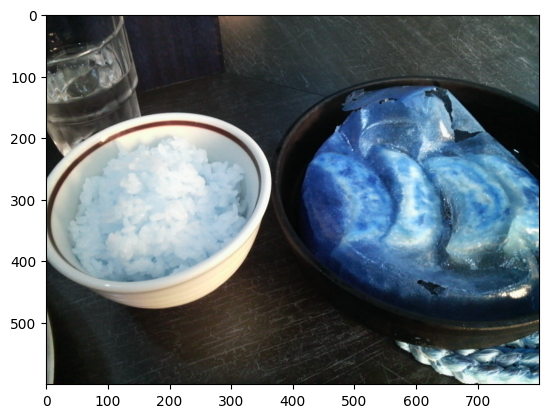

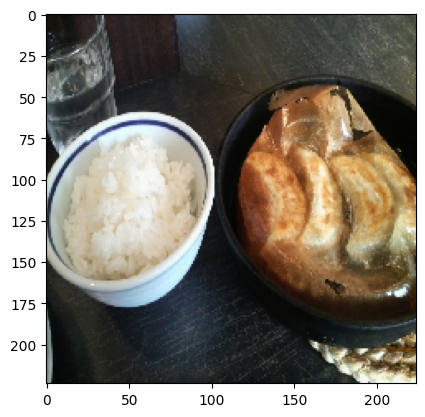

AttributeError: shape